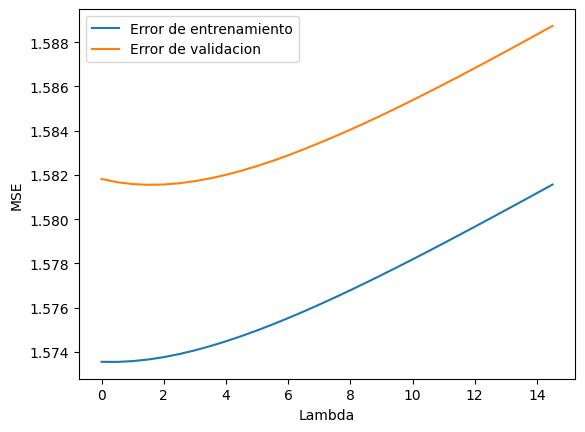

Lambda opt:  1.5
RMSE:  1.2575979065702314
MAE:  0.9984724310755382
R2:  0.5636446232653604


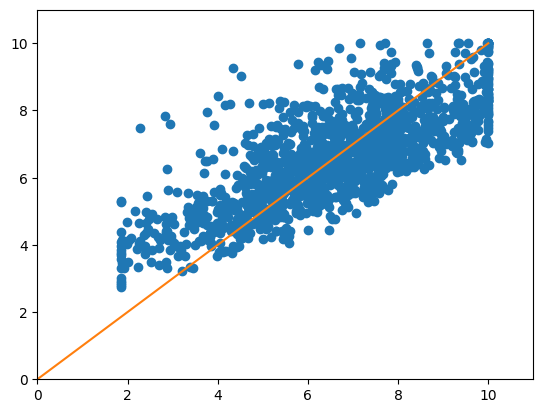

[[ 2.11358196]
 [-0.3249684 ]
 [ 0.4589151 ]
 [ 0.56876294]
 [ 0.11968532]
 [ 1.24772226]]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

def dataset(data):
    
    random.seed(47)
    data_ = list(zip( data['idx'], data['forecasted_performance'],data['hs_sleep'], data['hs_study'], data['prev_scores'], data['practice'], data['extracurricular_activities']))
    random.shuffle(data_)
    idx, y, x1, x2, x3, x4, x5 = zip(*data_)
    x1 = list(x1)
    x2 = list(x2)
    x3 = list(x3)
    x4 = list(x4)
    x5= list(x5)
    y = list(y)
    for i in range(len(x5)):
        if x5[i] == False:
            x5[i] = 0
        else:
            x5[i] = 1

    X = np.zeros((len(x1), 6))
    for i in range(len(X)):
        X[i][0] = 1
        X[i][1] = x1[i]
        X[i][2] = x2[i]
        X[i][3] = x3[i]
        X[i][4] = x4[i]
        X[i][5] = x5[i]
    
    Y = np.zeros((len(x1), 1))
    for i in range(len(Y)):
        Y[i] = y[i]

    return X, Y

def build_mat(data):
    matrix = np.zeros((len(data['x'][0]), len(data['x']) + 1)) # [muestras, parametros+1]
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if j == 0:
                matrix[i][j] = 1
            else:
                matrix[i][j] = data['x'][j-1][i]
    return matrix

def rmse(data, predict):
    return np.sqrt(np.mean((data - predict)**2))

def mae(data, predict):
    return np.mean(np.abs(data - predict))

def r2(data, predict):
    return 1 - (np.mean((data - predict) ** 2) / np.mean((data - np.mean(data) ) ** 2)) #chequear xq da negativo

def mse(data, predict):
    return np.mean((data - predict)**2)


def model(data, w):
    predict = np.zeros(len(data))
    for i in range(len(data)):
        for j in range(len(w)):
            predict[i] += w[j] * data[i][j]
    for i in range(len(predict)): #preguntar si esta bien hacer esto
        if predict[i] > 10:
            predict[i] = 10
        if predict[i] < 0:
            predict[i] = 0
    return predict


def train_model(data, lambda_):
    X = data['x'] # [muestras, parametros+1]
    X_t = np.transpose(X)
    w_opt = np.linalg.pinv((X_t @ X) + ( lambda_ * np.eye(len(X[0])))) @ X_t @ data['y'] # [params+1, 1]
    return w_opt

def test(path):
    lambda_ = 1.5
    W = [ 2.11358196,-0.3249684 , 0.4589151 , 0.56876294, 0.11968532, 1.24772226]
    data = pd.read_csv(path)
    X, Y = dataset(data)
    predict = model(X, W)
    rmse_err = rmse(Y, predict)
    mae_err = mae(Y, predict)
    r2_err = r2(Y, predict)
    print("RMSE: ", rmse_err)
    print("MAE: ", mae_err)
    print("R2: ", r2_err)


def main():
    ys_real_val = []
    ys_predic_val = []
    ys_real_train = []
    ys_predic_train = []
    error_by_lambda_val = []
    error_by_lambda_train = []
    data = pd.read_csv( 'datasets/Student_Performance_DEV.csv')
    folds = 10
    lambda_ = np.arange(0, 15, 0.5) 
    X, Y = dataset(data)
    for l in lambda_:
        y_real_val = []
        y_predic_val = []
        y_real_train = []
        y_predic_train = []
        for fold in range(folds):
            data_train = {'x': np.concatenate((X[:int((fold/folds)*len(X))], X[int((fold+1)/folds)*len(X):])), 'y': np.concatenate((Y[:int((fold/folds)*len(Y))], Y[int((fold+1)/folds)*len(Y):]))}
            data_val = {'x': X[int((fold/folds)*len(X)):int(((fold+1)/folds)*len(X))] , 'y': Y[int((fold/folds)*len(Y)):int(((fold+1)/folds)*len(Y))]}
            w = train_model(data_train, l)

            train_set_predictions = model(data_train['x'], w)
            val_set_predictions = model(data_val['x'], w)
            data_val_flat = data_val['y'].flatten()
            data_train_flat = data_train['y'].flatten()
            y_real_val = np.concatenate((y_real_val, data_val_flat)) if len(y_real_val) > 0 else  data_val_flat
            y_predic_val = np.concatenate((y_predic_val, val_set_predictions))
            y_real_train = np.concatenate((y_real_train, data_train_flat)) if len(y_real_train) > 0 else  data_train_flat
            y_predic_train = np.concatenate((y_predic_train, train_set_predictions))
        ys_real_val.append(y_real_val)
        ys_predic_val.append(y_predic_val)
        ys_real_train.append(y_real_train)
        ys_predic_train.append(y_predic_train)
        error_by_lambda_val.append(mse(y_real_val, y_predic_val))
        error_by_lambda_train.append(mse(y_real_train, y_predic_train))

    
    #2b

    plt.plot(lambda_, error_by_lambda_train, label='Error de entrenamiento')
    plt.plot(lambda_, error_by_lambda_val, label='Error de validacion')
    plt.xlabel("Lambda")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()


    #2c
    opt_lambda_idx = np.argmin(error_by_lambda_val)
    print("Lambda opt: ", lambda_[opt_lambda_idx])
    y_val_opt = ys_real_val[opt_lambda_idx]
    y_predic_opt = ys_predic_val[opt_lambda_idx]
    rmse_err = rmse(y_val_opt, y_predic_opt)
    mae_err = mae(y_val_opt, y_predic_opt)
    r2_err = r2(y_val_opt, y_predic_opt)
    print("RMSE: ", rmse_err)
    print("MAE: ", mae_err)
    print("R2: ", r2_err)

    plt.plot(y_val_opt, y_predic_opt, 'o')
    plt.plot(range(11), range(11))
    plt.ylim(0, 11)
    plt.xlim(0, 11)
    plt.show()


    # aca entrenamos un nuevo modelo con todos los datos y el mejor lambda encontrado
    chosen_lambda = lambda_[opt_lambda_idx]
    full_data = {'x': X, 'y': Y}
    W = train_model(full_data, chosen_lambda)
    print(W)

    #La funcion test es para qeu evaluen poniendo el path y obteniendo las metricas de error sobre el set de test
    #test(path)
    




main()